# <a id='toc1_'></a>[Image Captioning EDA](#toc0_)
Ananya Chattoraj

cananya53@gmail.com

**Table of contents**<a id='toc0_'></a>    
- [Image Captioning EDA](#toc1_)    
    - [Introduction to the Dataset](#toc1_1_1_)    
    - [EDA Process](#toc1_1_2_)    
    - [Limitations](#toc1_1_3_)    
  - [IMAGES](#toc1_2_)    
  - [Moving Forward](#toc1_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_1_'></a>[Introduction to the Dataset](#toc0_)
The dataset is the Flickr 8k images + captions dataset from Kaggle found [here](https://www.kaggle.com/datasets/aladdinpersson/flickr8kimagescaptions).

### <a id='toc1_1_2_'></a>[EDA Process](#toc0_)
The aim of EDA in this project is to familiarize myself with the dataset. I will consider the following questions:
- What is the size of this dataset?
- Are there any captions missing?
- How must the dataframe look for pre-processing?

### <a id='toc1_1_3_'></a>[Limitations](#toc0_)
It is important to note that due to computational and time limitations, this dataset may be heavily downsampled, impacting the utility of the resulting model. In future iterations, the entirety of the EDA, pre-processing, and modeling may be revisited to improve the utility of the final model.

A note on on notebook organization: as this was largely a learning project, many iterations were done that required re-pre-processing during the modeling process. The notebooks will document the entirety of my reasoning and iterative learning in order. To see the final model, check the "final" notebook.

Packages

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from PIL import Image
import os
import random
import glob
from sklearn.model_selection import train_test_split

Load in the captions as a data frame

In [7]:
caption = pd.read_csv('flickr8k/captions.txt')
caption.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [8]:
caption.shape

(40455, 2)

In [9]:
caption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    40455 non-null  object
 1   caption  40455 non-null  object
dtypes: object(2)
memory usage: 632.2+ KB


In [10]:
caption.isna().sum()

image      0
caption    0
dtype: int64

Thankfully, this is already a relatively clean caption set in the sense of missing values. Captions seem to include punctuation and capitalization. They are also of varying lengths. I suspect that there are exactly 5 captions per image. This will be checked for later. For now, I will explore the images.

## <a id='toc1_2_'></a>[IMAGES](#toc0_)

In [11]:
#getting image files
imagefolder = 'flickr8k/images/'

In [12]:
#list of all image paths
imagefiles = glob.glob(imagefolder + '/*.jpg')
imagefiles

['flickr8k/images\\1000268201_693b08cb0e.jpg',
 'flickr8k/images\\1001773457_577c3a7d70.jpg',
 'flickr8k/images\\1002674143_1b742ab4b8.jpg',
 'flickr8k/images\\1003163366_44323f5815.jpg',
 'flickr8k/images\\1007129816_e794419615.jpg',
 'flickr8k/images\\1007320043_627395c3d8.jpg',
 'flickr8k/images\\1009434119_febe49276a.jpg',
 'flickr8k/images\\1012212859_01547e3f17.jpg',
 'flickr8k/images\\1015118661_980735411b.jpg',
 'flickr8k/images\\1015584366_dfcec3c85a.jpg',
 'flickr8k/images\\101654506_8eb26cfb60.jpg',
 'flickr8k/images\\101669240_b2d3e7f17b.jpg',
 'flickr8k/images\\1016887272_03199f49c4.jpg',
 'flickr8k/images\\1019077836_6fc9b15408.jpg',
 'flickr8k/images\\1019604187_d087bf9a5f.jpg',
 'flickr8k/images\\1020651753_06077ec457.jpg',
 'flickr8k/images\\1022454332_6af2c1449a.jpg',
 'flickr8k/images\\1022454428_b6b660a67b.jpg',
 'flickr8k/images\\1022975728_75515238d8.jpg',
 'flickr8k/images\\102351840_323e3de834.jpg',
 'flickr8k/images\\1024138940_f1fefbdce1.jpg',
 'flickr8k/image

In [13]:
#I'll want to see some of the images, so define function to display them
def display_image(ipath):
    images = Image.open(ipath)
    plt.imshow(images)
    plt.show()

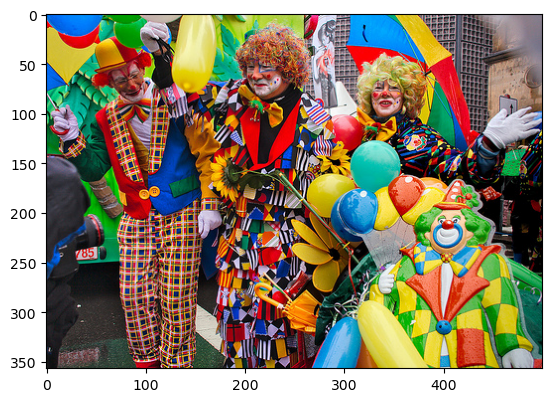

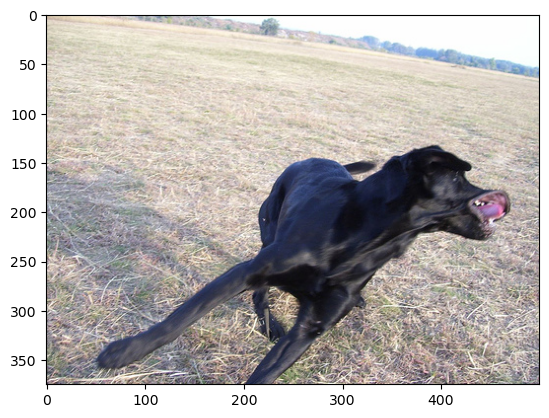

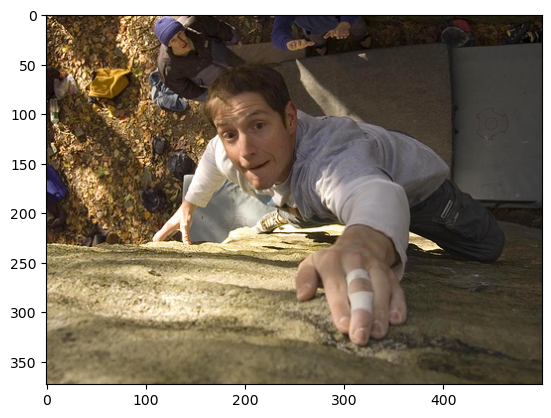

In [14]:
#display 3 random images for sanity check 
randomimages = random.sample(imagefiles,3)
for r in randomimages:
    display_image(r)


It seems as though these are random images of people, animals, and events. I will later inspect the word frequencies of captions to check the content skew of the images.

In [15]:
#I'm not actually sure whether i'll need the paths like this for pre-processing and modeling, but I'll start off with it anyways
ipathsdf = pd.DataFrame({'paths':imagefiles})
ipathsdf.head()

,paths
0,flickr8k/images\1000268201_693b08cb0e.jpg
1,flickr8k/images\1001773457_577c3a7d70.jpg
2,flickr8k/images\1002674143_1b742ab4b8.jpg
3,flickr8k/images\1003163366_44323f5815.jpg
4,flickr8k/images\1007129816_e794419615.jpg


In [16]:
ipathsdf['image'] = ipathsdf['paths'].apply(lambda path: path.split('\\')[-1])
ipathsdf.head()

,paths,image
0,flickr8k/images\1000268201_693b08cb0e.jpg,1000268201_693b08cb0e.jpg
1,flickr8k/images\1001773457_577c3a7d70.jpg,1001773457_577c3a7d70.jpg
2,flickr8k/images\1002674143_1b742ab4b8.jpg,1002674143_1b742ab4b8.jpg
3,flickr8k/images\1003163366_44323f5815.jpg,1003163366_44323f5815.jpg
4,flickr8k/images\1007129816_e794419615.jpg,1007129816_e794419615.jpg


In [17]:
mergeddf = ipathsdf.merge(caption, on='image', how='left')

In [18]:
mergeddf.head()

,paths,image,caption
0,flickr8k/images\1000268201_693b08cb0e.jpg,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,flickr8k/images\1000268201_693b08cb0e.jpg,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,flickr8k/images\1000268201_693b08cb0e.jpg,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,flickr8k/images\1000268201_693b08cb0e.jpg,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,flickr8k/images\1000268201_693b08cb0e.jpg,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [19]:
mergeddf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40455 entries, 0 to 40454
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   paths    40455 non-null  object
 1   image    40455 non-null  object
 2   caption  40455 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [20]:
#checkpoint
mergeddf.to_pickle('image_captions')

I should look at some pictures and one of their captions together to make sure the captions actually make sense. To do this, I'll run two types of checks: a random image + caption and same image + different captions. The first check will give me an idea of an overall comprehensibility of the captions given an image and the second check will give me an idea of the quality of multiple captions for an image.

Random image + captions

In [21]:
from textwrap import wrap

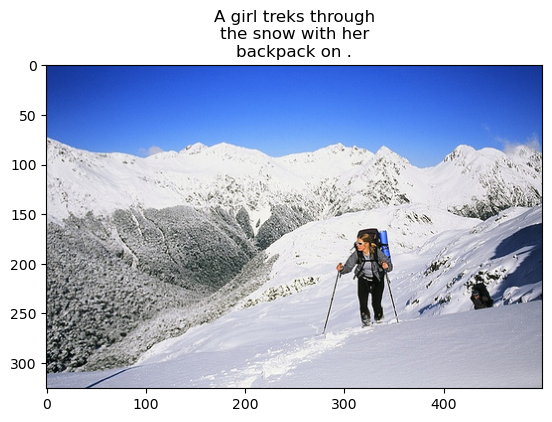

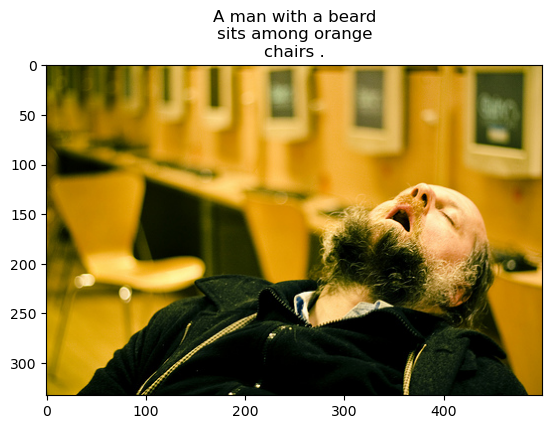

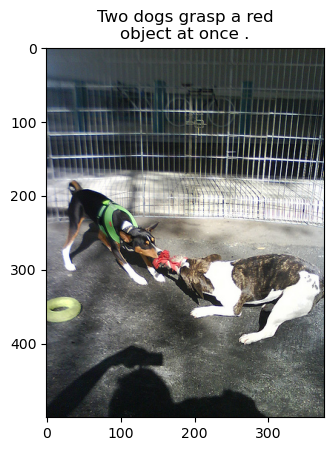

In [22]:
#random images + captions
imagelist = mergeddf['paths'].tolist()
captionlist = mergeddf['caption'].tolist()
pairs = list(zip(imagelist,captionlist))
samples = random.sample(pairs,3)
for p, c in samples:
    plt.title("\n".join(wrap(c, 20)))
    display_image(p)
    plt.show

Single image + multiple captions

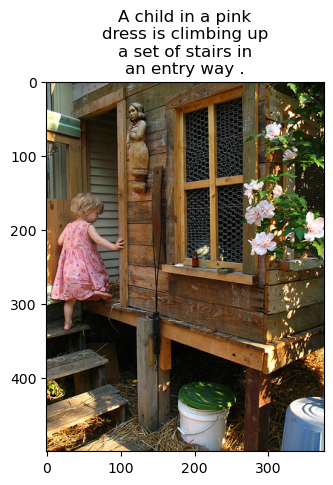

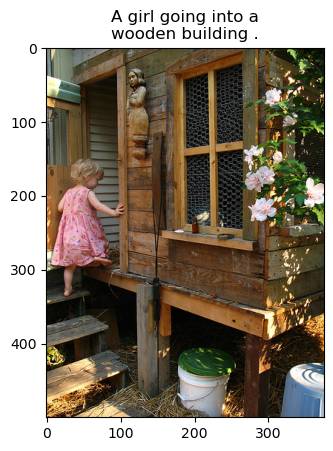

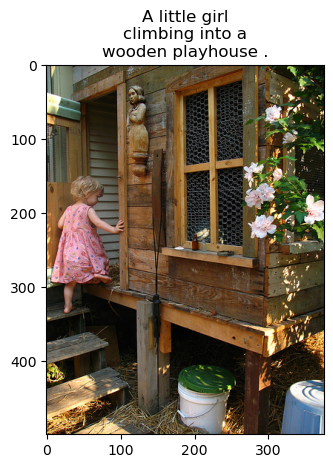

In [23]:
#single image and 3 of its captions
imagelist = mergeddf['paths'].tolist()
captionlist = mergeddf['caption'].tolist()
pairs = list(zip(imagelist,captionlist))
samples = pairs[:3]
for p, c in samples:
    plt.title("\n".join(wrap(c, 20)))
    display_image(p)
    plt.show

The captions all seem to reasonable capture the contents of their images. Obviously, the captions aren't exhaustive (pictures are worth 1000 words and whatnot), and captioning techniques are heavily context dependent (something a simple model won't pick up on), but for my current purposes, these captions will work.

It is important to ensure that all images have the same number of captions.

In [24]:
mergeddf.groupby(['image'])['caption'].count().describe()

count    8091.0
mean        5.0
std         0.0
min         5.0
25%         5.0
50%         5.0
75%         5.0
max         5.0
Name: caption, dtype: float64

Since all images have an equal number of captions, I don't need to impute anything or discard any particular images from modeling (outside of downsampling needs).

Currently, the captions are all in a column. I'm not actually sure what state is best for my final dataframe, but it might be helpful to rearrange this such that each caption is in its own column. In order to evaluate a model, I will need to use at least a single caption as a ground truth, so I want the captions easily accessible on their own.

In [26]:
# I'll put the captions into their own columns by first numbering the caption order they are present in and then associatin those numbers with columns.
mergeddf['caption_order'] = mergeddf.groupby(['paths']).cumcount()+1
mergeddf

,paths,image,caption,caption_order
0,flickr8k/images\1000268201_693b08cb0e.jpg,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,1
1,flickr8k/images\1000268201_693b08cb0e.jpg,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,2
2,flickr8k/images\1000268201_693b08cb0e.jpg,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,3
3,flickr8k/images\1000268201_693b08cb0e.jpg,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,4
4,flickr8k/images\1000268201_693b08cb0e.jpg,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,5
...,...,...,...,...
40450,flickr8k/images\997722733_0cb5439472.jpg,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face,1
40451,flickr8k/images\997722733_0cb5439472.jpg,997722733_0cb5439472.jpg,A man is rock climbing high in the air .,2
40452,flickr8k/images\997722733_0cb5439472.jpg,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...,3
40453,flickr8k/images\997722733_0cb5439472.jpg,997722733_0cb5439472.jpg,A rock climber in a red shirt .,4


In [30]:
# I have realized that I might not need the path format with os.join so I will use that in future notebooks and leave the paths column behind.
mergeddf = mergeddf.pivot(index='image', columns='caption_order', values='caption').reset_index()


KeyboardInterrupt



In [28]:
mergeddf

caption_order,image,1,2,3,4,5
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,A girl going into a wooden building .,A little girl climbing into a wooden playhouse .,A little girl climbing the stairs to her playh...,A little girl in a pink dress going into a woo...
1,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting,A black dog and a tri-colored dog playing with...,A black dog and a white dog with brown spots a...,Two dogs of different breeds looking at each o...,Two dogs on pavement moving toward each other .
2,1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front o...,A little girl is sitting in front of a large p...,A small girl in the grass plays with fingerpai...,There is a girl with pigtails sitting in front...,Young girl with pigtails painting outside in t...
3,1003163366_44323f5815.jpg,A man lays on a bench while his dog sits by him .,A man lays on the bench to which a white dog i...,a man sleeping on a bench outside with a white...,A shirtless man lies on a park bench with his ...,man laying on bench holding leash of dog sitti...
4,1007129816_e794419615.jpg,A man in an orange hat starring at something .,A man wears an orange hat and glasses .,A man with gauges and glasses is wearing a Bli...,A man with glasses is wearing a beer can croch...,The man with pierced ears is wearing glasses a...
...,...,...,...,...,...,...
8086,990890291_afc72be141.jpg,A man does a wheelie on his bicycle on the sid...,A man is doing a wheelie on a mountain bike .,A man on a bicycle is on only the back wheel .,Asian man in orange hat is popping a wheelie o...,Man on a bicycle riding on only one wheel .
8087,99171998_7cc800ceef.jpg,A group is sitting around a snowy crevasse .,A group of people sit atop a snowy mountain .,A group of people sit in the snow overlooking ...,Five children getting ready to sled .,Five people are sitting together in the snow .
8088,99679241_adc853a5c0.jpg,A grey bird stands majestically on a beach whi...,A large bird stands in the water on the beach .,A tall bird is standing on the sand beside the...,A water bird standing at the ocean 's edge .,A white crane stands tall as it looks out upon...
8089,997338199_7343367d7f.jpg,A person stands near golden walls .,a woman behind a scrolled wall is writing,A woman standing near a decorated wall writes .,The walls are covered in gold and patterns .,"Woman writing on a pad in room with gold , dec..."


In [29]:
#pickle time
mergeddf.to_pickle('captions_by_path.pkl')

In my first set of model iterations, I will take just a single caption per image. This will help keep the technical resources requirement and model training time low. To this end, I will separate out each caption file and save everything.

In [95]:
mergeddf[['image', 1]].to_pickle('caption1.pkl')
mergeddf[['image', 2]].to_pickle('caption2.pkl')
mergeddf[['image', 3]].to_pickle('caption3.pkl')
mergeddf[['image', 4]].to_pickle('caption4.pkl')
mergeddf[['image', 5]].to_pickle('caption5.pkl')

## <a id='toc1_3_'></a>[Moving Forward](#toc0_)

This was just a basic EDA to familiarize myself with the dataset. I have learned that the images all have the same amount of captions and that the captions are relatively clean in the sense that there are no nulls. In pre-processing, I will continue to explore the data in deeper detail.